### COBA CROPPTED

In [4]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO  # Ensure you have the YOLOv8 library installed

# Load the pre-trained YOLOv8 model
model = YOLO("runs/detect/train2/weights/best.pt")

def detect_areas(img_path):
    """
    Detects areas in the image based on the trained YOLO model and draws bounding boxes.
    
    Args:
        img_path (str): Path to the input image.

    Returns:
        List[Tuple[int, int, int, int, int]]: A list of detected bounding boxes
        in the format (x1, y1, x2, y2, class_id) and the image with drawn boxes.
    """
    # Read the image from the specified path
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to read: {img_path}")

    # Run the model on the image
    results = model(img)
    detections = []

    # Process the results to extract bounding boxes and class IDs
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            class_id = int(box.cls[0])
            detections.append((x1, y1, x2, y2, class_id))

            # Draw bounding box on the image
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue color box
            cv2.putText(img, f'Class: {class_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return detections, img

def display_image(img):
    """
    Displays the image using matplotlib.
    
    Args:
        img (numpy.ndarray): The image to display.
    """
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


0: 416x640 1 NIK, 1 Nama, 1 Alamat, 209.0ms
Speed: 0.0ms preprocess, 209.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)
Detections:
Bounding Box: (129, 45, 374, 76), Class ID: 0
Bounding Box: (141, 82, 279, 102), Class ID: 1
Bounding Box: (143, 130, 204, 149), Class ID: 2


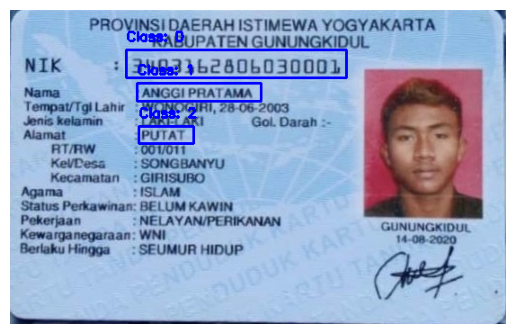

In [ ]:
def main():
    img_path = "kapal-tenggelam.jpg"

    try:
        detections, img_with_boxes = detect_areas(img_path)
        print("Detections:")
        for detection in detections:
            print(f"Bounding Box: {detection[:4]}, Class ID: {detection[4]}")
        
        # Display the image with bounding boxes
        display_image(img_with_boxes)
    except ValueError as e:
        print(e)

if __name__ == "__main__":
    main()

In [ ]:
from ultralytics import YOLO
import cv2

# Initialize YOLO model
model = YOLO("runs/detect/train2/weights/best.pt")

# Detect objects in an image
def detect_and_crop(image_path, output_folder):
    img = cv2.imread(image_path)
    results = model(img)
    boxes = results[0].boxes  

    cropped_images = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cropped = img[y1:y2, x1:x2]
        cropped_images.append(cropped)

        # Save cropped regions (optional)
        output_path = f"{output_folder}/crop_{i}.jpg"
        cv2.imwrite(output_path, cropped)
        print(f"Saved: {output_path}")
    return cropped_images

# Example usage
detect_and_crop("kapal-tenggelam.jpg", "output/cropped_regions")


0: 416x640 1 NIK, 1 Nama, 1 Alamat, 246.4ms
Speed: 13.0ms preprocess, 246.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)
Saved: output/cropped_regions/crop_0.jpg
Saved: output/cropped_regions/crop_1.jpg
Saved: output/cropped_regions/crop_2.jpg


[array([[[231, 193, 158],
         [235, 195, 160],
         [234, 194, 159],
         ...,
         [227, 190, 156],
         [225, 188, 154],
         [225, 189, 153]],
 
        [[219, 181, 147],
         [223, 185, 151],
         [227, 189, 155],
         ...,
         [224, 188, 152],
         [223, 189, 153],
         [221, 188, 149]],
 
        [[236, 198, 164],
         [238, 200, 166],
         [239, 201, 167],
         ...,
         [220, 184, 148],
         [224, 191, 152],
         [223, 190, 151]],
 
        ...,
 
        [[241, 202, 164],
         [244, 205, 167],
         [243, 204, 166],
         ...,
         [239, 200, 168],
         [237, 199, 167],
         [234, 196, 164]],
 
        [[231, 194, 156],
         [235, 196, 158],
         [233, 194, 156],
         ...,
         [240, 202, 172],
         [240, 202, 172],
         [237, 199, 169]],
 
        [[233, 196, 158],
         [236, 197, 159],
         [234, 195, 157],
         ...,
         [233, 195, 165],
  

### PREPROCESSING CROPPTED DATASET

In [27]:
import cv2
import numpy as np
import os

def preprocess_image(image):
    # Resize image (upscale for better OCR performance)
    scale_factor = 2.0
    image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Contrast adjustment using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(gray)

    # Denoise using bilateral filter
    denoised = cv2.bilateralFilter(contrast_enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # Thresholding (adaptive)
    binary = cv2.adaptiveThreshold(
        denoised, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 2
    )

    # Morphological processing (closing gaps)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return processed

# Example usage
image_path = "output/cropped_regions/crop_2.jpg"
output_dir = "output/preprocessed/"
os.makedirs(output_dir, exist_ok=True)

cropped_img = cv2.imread(image_path)
if cropped_img is None:
    raise ValueError(f"Failed to load image. Check the file path: {image_path}")

processed_img = preprocess_image(cropped_img)
save_status = cv2.imwrite(f"{output_dir}/crop_2_processed.jpg", processed_img)

if not save_status:
    raise IOError("Failed to save the processed image.")
print("Image preprocessing and saving completed successfully!")


Image preprocessing and saving completed successfully!


### FULL DATASET Cropped

In [34]:
import cv2
import os

def crop_regions(image_path, txt_path, output_dir, image_name):
    """
    Crop detected regions using YOLO bounding box predictions.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    h, w, _ = image.shape  # Get image dimensions

    # Read bounding box data
    with open(txt_path, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        # Parse bounding box details
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())

        # Convert YOLO format (normalized) to pixel values
        x_min = max(0, int((x_center - bbox_width / 2) * w))
        y_min = max(0, int((y_center - bbox_height / 2) * h))
        x_max = min(w, int((x_center + bbox_width / 2) * w))
        y_max = min(h, int((y_center + bbox_height / 2) * h))

        # Crop the region
        cropped = image[y_min:y_max, x_min:x_max]

        # Save the cropped region
        output_path = os.path.join(output_dir, f"{image_name}_crop_{i}.jpg")
        if not cv2.imwrite(output_path, cropped):
            print(f"Failed to save cropped image: {output_path}")
        else:
            print(f"Saved cropped image: {output_path}")

# Paths
input_images_dir = "datasetKTP/val/images"  # Folder with KTP images
input_labels_dir = "runs/detect/predict7/labels"  # YOLO prediction .txt files
output_dir = "cropped_datasetKTP/val/images"  # Folder to save cropped regions

os.makedirs(output_dir, exist_ok=True)  # Ensure output folder exists

# Process each image
for image_name in os.listdir(input_images_dir):
    if image_name.endswith(".jpg"):  # Process only .jpg files
        image_path = os.path.join(input_images_dir, image_name)
        txt_path = os.path.join(input_labels_dir, image_name.replace(".jpg", ".txt"))
        
        # Crop and save regions
        if os.path.exists(txt_path):
            crop_regions(image_path, txt_path, output_dir, image_name.split(".")[0])
        else:
            print(f"Label file not found for {image_name}: {txt_path}")


Saved cropped image: cropped_datasetKTP/val/images\3276055209990005_crop_0.jpg
Saved cropped image: cropped_datasetKTP/val/images\3276055209990005_crop_1.jpg
Saved cropped image: cropped_datasetKTP/val/images\3276055209990005_crop_2.jpg
Saved cropped image: cropped_datasetKTP/val/images\3278023003810008_crop_0.jpg
Saved cropped image: cropped_datasetKTP/val/images\3278023003810008_crop_1.jpg
Saved cropped image: cropped_datasetKTP/val/images\3278023003810008_crop_2.jpg
Saved cropped image: cropped_datasetKTP/val/images\3278023003810008_crop_3.jpg
Saved cropped image: cropped_datasetKTP/val/images\3301084206980004_crop_0.jpg
Saved cropped image: cropped_datasetKTP/val/images\3301084206980004_crop_1.jpg
Saved cropped image: cropped_datasetKTP/val/images\3301084206980004_crop_2.jpg
Saved cropped image: cropped_datasetKTP/val/images\3301224610000006_crop_0.jpg
Saved cropped image: cropped_datasetKTP/val/images\3301224610000006_crop_1.jpg
Saved cropped image: cropped_datasetKTP/val/images\3